# Calculate the barotropic stream function on the ORCA grid

## Preamble: Import modules, turn off warnings, etc.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%load_ext memory_profiler
from dask.distributed import Client, wait
import gsw
import inspect
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
!ls ../scheduler.log

../scheduler.log


In [4]:
try:
    client = Client(scheduler_file="../scheduler.json")
    client.restart()
    display(client)
except Exception as e:
    print("No scheduler.  Will continue in single-process mode.")

Client Scheduler: tcp://192.168.0.2:8786 Dashboard: http://192.168.0.2:8787/status,Cluster Workers: 3 Cores: 3 Memory: 12.52 GB


## Load the whole model run into a single grid-aware data set

In [5]:
data_path = Path("../example-data/ORCA05.L46-KKG36F25H/")

In [6]:
data_files = (
    sorted(data_path.glob("ORCA05.L46-KKG36F25H_1m_*_grid_?.nc")) +
    [data_path / "mesh_mask.nc",
     data_path / "new_maskglo.nc"]
)

In [7]:
list(map(print, data_files));

../example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20080101_20081231_grid_T.nc
../example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20080101_20081231_grid_U.nc
../example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20080101_20081231_grid_V.nc
../example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20090101_20091231_grid_T.nc
../example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20090101_20091231_grid_U.nc
../example-data/ORCA05.L46-KKG36F25H/ORCA05.L46-KKG36F25H_1m_20090101_20091231_grid_V.nc
../example-data/ORCA05.L46-KKG36F25H/mesh_mask.nc
../example-data/ORCA05.L46-KKG36F25H/new_maskglo.nc


In [8]:
from xorca.lib import preprocess_orca

ds = xr.open_mfdataset(data_files,
                       preprocess=(lambda ds:
                                   preprocess_orca(data_path / "mesh_mask.nc", ds)))
ds = ds.chunk({"t": 1, "z_c": 23, "z_l": 23})
ds

<xarray.Dataset>
Dimensions:   (t: 24, x_c: 720, x_r: 720, y_c: 509, y_r: 509, z_c: 46, z_l: 46)
Coordinates:
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    llon_rr   (y_r, x_r) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    depth_c   (z_c) float64 dask.array<shape=(46,), chunksize=(23,)>
    llat_cc   (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    llon_cc   (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    llat_rc   (y_r, x_c) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    llon_

## Calculate Sigma

In [9]:
%%memit
SA = ds.vosaline
SA = SA.where(ds.tmask != 0)

peak memory: 246.55 MiB, increment: 0.19 MiB


In [10]:
%%memit
CT = ds.votemper
CT = CT.where(ds.tmask != 0)

peak memory: 246.62 MiB, increment: 0.03 MiB


In [11]:
%%memit
sigma0 =  xr.apply_ufunc(gsw.sigma0, SA, CT, dask='parallelized', output_dtypes=[float, ])

peak memory: 246.63 MiB, increment: 0.00 MiB


In [12]:
sigma0

<xarray.DataArray (t: 24, z_c: 46, y_c: 509, x_c: 720)>
dask.array<shape=(24, 46, 509, 720), dtype=float64, chunksize=(1, 23, 509, 720)>
Coordinates:
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    depth_c  (z_c) float64 dask.array<shape=(46,), chunksize=(23,)>
    llat_cc  (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
    llon_cc  (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(509, 720)>
  * t        (t) datetime64[ns] 2008-01-16T12:00:00 2008-02-15 ...

In [13]:
# %%memit
# sigma0.isel(t=0, x_c=100, y_c=100).compute().plot();

In [14]:
ds["sigma0"] = sigma0

In [15]:
ds = ds.isel(t=0, x_c=100, x_r=100)
ds

<xarray.Dataset>
Dimensions:   (y_c: 509, y_r: 509, z_c: 46, z_l: 46)
Coordinates:
    x_r       float64 101.5
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
    x_c       int64 101
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    llon_rr   (y_r) float32 dask.array<shape=(509,), chunksize=(509,)>
    depth_c   (z_c) float64 dask.array<shape=(46,), chunksize=(23,)>
    llat_cc   (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    llon_cc   (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    llat_rc   (y_r) float32 dask.array<shape=(509,), chunksize=(509,)>
    llon_cr   (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    llat_rr   (y_r) float32 dask.array<shape=(509,), chunksize=(509,)>
    depth_l   (z_l) float64 dask.array<shape=(46,), c

In [16]:
T = ds.votemper
s0 = ds.sigma0

In [17]:
display(T)
display(s0)

<xarray.DataArray 'votemper' (z_c: 46, y_c: 509)>
dask.array<shape=(46, 509), dtype=float32, chunksize=(23, 509)>
Coordinates:
    x_r      float64 101.5
    x_c      int64 101
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    depth_c  (z_c) float64 dask.array<shape=(46,), chunksize=(23,)>
    llat_cc  (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    llon_cc  (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    llon_cr  (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    llat_cr  (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    t        datetime64[ns] 2008-01-16T12:00:00

<xarray.DataArray 'sigma0' (z_c: 46, y_c: 509)>
dask.array<shape=(46, 509), dtype=float64, chunksize=(23, 509)>
Coordinates:
    x_r      float64 101.5
    x_c      int64 101
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    depth_c  (z_c) float64 dask.array<shape=(46,), chunksize=(23,)>
    llat_cc  (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    llon_cc  (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    llon_cr  (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    llat_cr  (y_c) float32 dask.array<shape=(509,), chunksize=(509,)>
    t        datetime64[ns] 2008-01-16T12:00:00

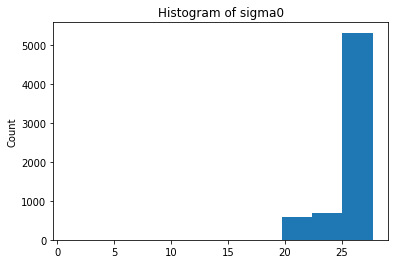

In [18]:
s0.plot.hist();

In [19]:
s0 = s0.persist()
T = T.persist()
wait(s0);
wait(T);

In [20]:
Tg = T.groupby_bins(s0, np.arange(18, 30, 0.5))

In [21]:
Tmax = xr.concat((arr.unstack("stacked_z_c_y_c") for val, arr in Tg),
                 dim="s0")
Tmax.coords["s0"] = (["s0", ],
                     np.asarray([val.mid for val, arr in Tg]))

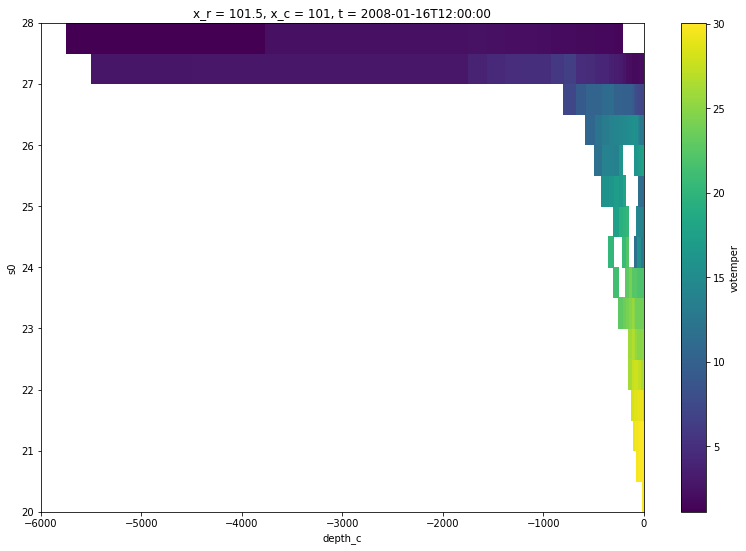

In [32]:
Tmax.coords["depth_c"] = ds.coords["depth_c"]
Tmax.sortby("s0").max("y_c").plot.pcolormesh("depth_c", "s0", size=9);